# Simple chatbot

We follow the [langgraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/introduction/) to learn the basics by building a simple chatbot.

## Get an LLM

Building a chatbot will require having access to an LLM provider such as Anthropic or OpenAI, or running a local Llama model.
Here, we will go with Anthropic.
We have defined the environment variable `"ANTHROPIC_API_KEY"` in the `.env` file thta we load right below.

In [ ]:
from dotenv import load_dotenv
from typing import Annotated, Literal

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict


load_dotenv()
llm = init_chat_model(model="anthropic:claude-3-5-sonnet-latest")

# Define the state

In langgraph, we build workflows whose structure is represented by a graph (who would've guessed?).
The graph defines the flow of our system's _state_, where the nodes are functions that transform the state, and the edges specify how the state is passed between these functions.

Let's start by defining the state.
In this simple chatbot, the state contains the history of messages.

In [ ]:
class State(TypedDict):
    # The state contains the message history: a list that we change with the add_messages function
    # New messages are appended to the list, rather than replacing the previous ones.
    messages: Annotated[list, add_messages]

## Build the graph

Now we can build the graph.
In langgraph we use the `StateGraph` class to orchestrate the flow of the state.

In [ ]:
graph_builder = StateGraph(State)

At the moment, this graph is empty.
We need to add the corresponding nodes and edges to it that will make our chatbot work.

In this simple case, we will have a single function that will take the user input and generate a response with the LLM.
The node functions always take the current state as input and returns an updated one.

Since we have provided the reducer function `add_messages` to our state,  that will take care of appending new messages automatically.
Without a reducer function, the state would be overwritten.

In [ ]:
def chatbot(state: State) -> State:
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)  # Unique node name and function being called

<langgraph.graph.state.StateGraph>

Now that we have the node, we need to define how it is connected to the rest of the graph.
In this case, we will go from start to chatbot and from chatbot to end.
The `START` and `END` nodes tell the system where to start the work, and when to exit.

In [ ]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

<langgraph.graph.state.StateGraph>

Finally, once we have defined all the nodes and edges, we can compile the graph builder to complete the graph.

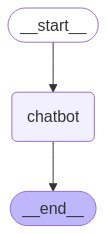

In [ ]:
graph = graph_builder.compile()

# Visualize the graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Running the chatbot

Compiled graphs can be invoked on a state.
Let's see an example!

In [ ]:
user_input = "Hello, how are you?"
state = graph.invoke({"messages": [{"role": "user", "content": user_input}]})  # Running the graph returns a state

# The response is the last message in the list
# The messages are of type `HumanMessage` and `AIMessage` from langchain
chatbot_response = state["messages"][-1].content
print(chatbot_response)

Hi! I'm doing well, thanks for asking. How are you today?


Great! Now let's build a chat loop

In [ ]:
def stream_graph_updates(user_input: str):
    print("User:", user_input)
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
    print("\n")


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:  # commands to terminate the conversation
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Hi, what can you tell me about red pandas?
Assistant: Red pandas (Ailurus fulgens) are small, tree-dwelling mammals native to the eastern Himalayas and southwestern China. Here are some key facts about red pandas:

1. Physical characteristics:
- About the size of a large house cat
- Reddish-brown fur
- White facial markings
- Long, bushy tail
- Sharp, retractable claws

2. Diet:
- Primarily bamboo (about 95% of their diet)
- Also eat fruits, insects, and small mammals

3. Habitat:
- Temperate forests
- High-altitude areas (2,200-4,800 meters)
- Areas with bamboo understory

4. Conservation status:
- Endangered species
- Main threats include habitat loss and fragmentation
- Estimated fewer than 10,000 adults remain in the wild

5. Interesting facts:
- Not closely related to giant pandas
- More closely related to raccoons and weasels
- Excellent climbers
- Mostly solitary animals
- Can lower their metabolic rate to conserve energy

Red pandas are protected by law in several countri